# Исследование объявлений о продаже квартир

**Общая информация:** В нашем распоряжении данные сервиса Яндекс. Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нам нужно провести начальный анализ предоставленных данных и установить влияние параметров продаваемых объектов на цену и сроки продажи. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

**Цель исследования:** проанализировать, как быстро продавались квартиры и как следующие параметры влияли на ее стоимость: общая площадь, жилая площадь, площадь кухни, количество комнат, категория этажа, на котором расположена квартира (первый, последний, другой), дата размещения (день недели, месяц, год). Мы так же посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений и вычислим среднюю цену каждого километра по мере удаления от центра города.

**Описание данных**

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

- `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
- `balcony` — число балконов
- `ceiling_height` — высота потолков (м)
- `cityCenters_nearest` — расстояние до центра города (м)
- `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
- `first_day_exposition` — дата публикации
- `floor` — этаж
- `floors_total` — всего этажей в доме
- `is_apartment` — апартаменты (булев тип)
- `kitchen_area` — площадь кухни в квадратных метрах (м²)
- `last_price` — цена на момент снятия с публикации
- `living_area` — жилая площадь в квадратных метрах (м²)
- `locality_name` — название населённого пункта
- `open_plan` — свободная планировка (булев тип)
- `parks_around3000` — число парков в радиусе 3 км
- `parks_nearest` — расстояние до ближайшего парка (м)
- `ponds_around3000` — число водоёмов в радиусе 3 км
- `ponds_nearest` — расстояние до ближайшего водоёма (м)
- `rooms` — число комнат
- `studio` — квартира-студия (булев тип)
- `total_area` — общая площадь квартиры в квадратных метрах (м²)
- `total_images` — число фотографий квартиры в объявлении

**План работы:**

1. Подключение необходимых библиотек
2. Ознакомление с предоставленным данными
3. Предобработка данных (удаление пропусков и обработка аномалий)
4. Добавление новых столбцов
5. Исследовательский анализ данных
6. Общие выводы

---

### Имортируем необходимые библиотеки

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

### Откроем файл с данными и изучим общую информацию. 

In [95]:
df = pd.read_csv('/datasets/real_estate_data.csv')
df.head()

,total_images\tlast_price\ttotal_area\tfirst_day_exposition\trooms\tceiling_height\tfloors_total\tliving_area\tfloor\tis_apartment\tstudio\topen_plan\tkitchen_area\tbalcony\tlocality_name\tairports_nearest\tcityCenters_nearest\tparks_around3000\tparks_nearest\tponds_around3000\tponds_nearest\tdays_exposition
0,20\t13000000.0\t108.0\t2019-03-07T00:00:00\t3\...
1,7\t3350000.0\t40.4\t2018-12-04T00:00:00\t1\t\t...
2,10\t5196000.0\t56.0\t2015-08-20T00:00:00\t2\t\...
3,0\t64900000.0\t159.0\t2015-07-24T00:00:00\t3\t...
4,2\t10000000.0\t100.0\t2018-06-19T00:00:00\t2\t...


Видим, что не смотря на расширение файла .csv (comma-separated values), разделителем является не запятая, а знаки табуляции (\t). Учтем это при чтении файла, указав значение разделителя.

In [96]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
pd.set_option('display.max_columns', None)
df.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Так намного лучше. Сделаем копию нашего датасета, чтобы в конце можно было определить масшатбность преобразований. И затем, посмотрим общую информацию о датасете

In [97]:
df_original = df.copy()

def dataframe_info(df):
    print('Первые пять строк датасета:')
    display(df.head())
    print()
    print('Начальная статистика датасета:')
    display(df.describe())
    print()
    print('Информация о структуре:')
    display(df.info())
    print()
    print('Явные дубликаты:')
    display(df.duplicated().value_counts())

dataframe_info(df)

Первые пять строк датасета:


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0



Начальная статистика датасета:


,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000



Информация о структуре:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 

None


Явные дубликаты:


False    23699
dtype: int64

Почти 24 000 строк, 22 столбца, и почти две трети столбцов имеют пропуски в значениях. Хорошо, что в датасете отсутсвуют явные дубликаты, но здесь есть над чем поработать. 

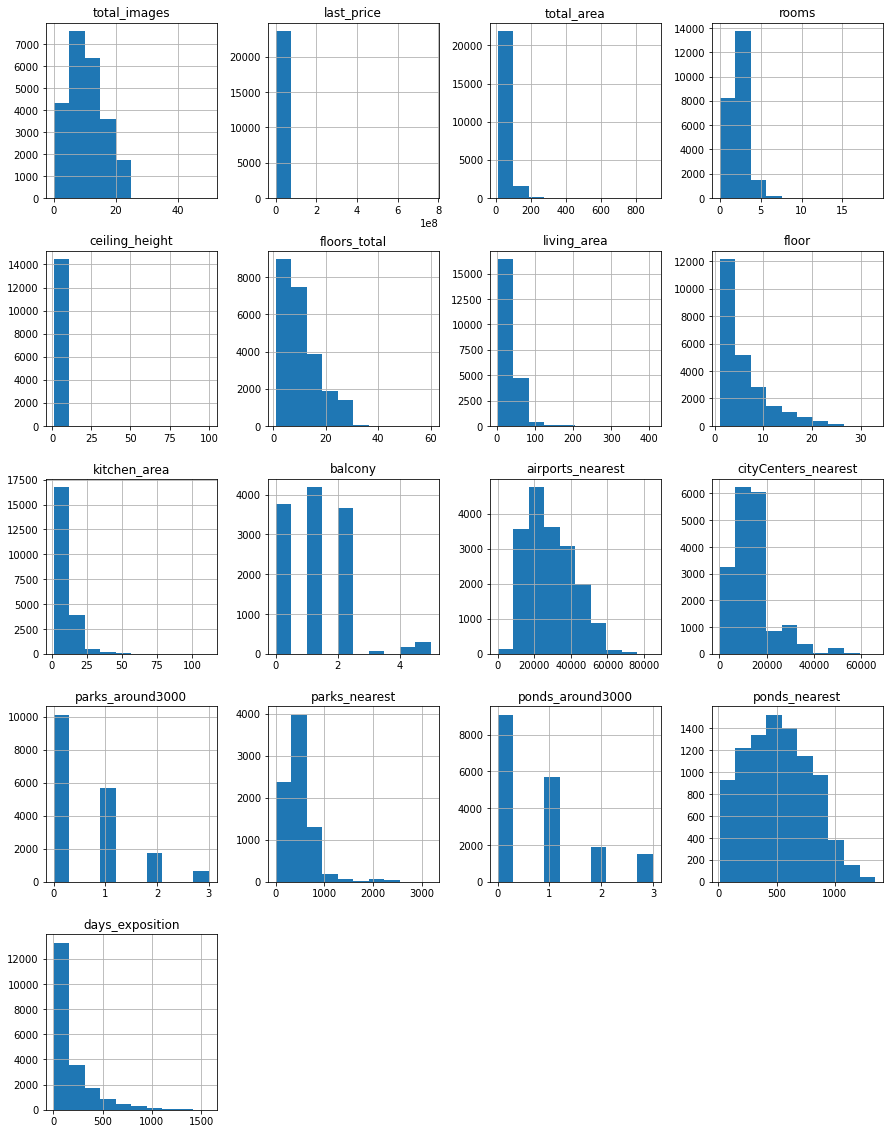

In [98]:
df.hist(figsize=(15, 20));

Что мы видим? Здесь есть над чем поработать. Такие графики как `floors_total`, `airports_nearest` или `total_images` демонстрируют нормальное распределение и отсутствие аномалий, на других графиках картина менее приятная и перед анализом придется рассмотреть каждый из них, чтобы привести данные в этих колонках к должному виду. Сразу видно, что в колонке `celinings_height` - высота потолков есть значения до 100 метров, и это явная ошибка. Цены в колонке last_price уходят до 800 млн рублей, а в колонке общей жилой площади есть объявления по 800 м2.


### Предобработка данных

#### Цена

В задании от заказчика сказано "Изучите, зависит ли цена от...". Значим столбец `last_price` - главное, что будем анализировать. Судя по построенной гистограмме выше, там что-то не то. Совсем не похоже на нормальное распределение. Изучим, что не так.

Одинокий столбец в начале графика в диапазоне от 0 до 100 000 000 (масштаб 1е8 говорит нам, что на оси Х цифры с восемью нулями). А точнее не до 100, а где-то до 40.

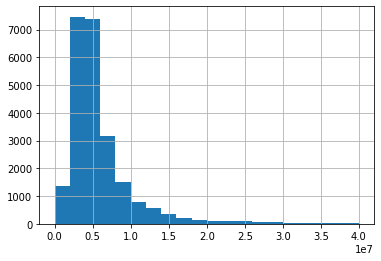

In [99]:
df['last_price'].hist(range=(0,40000000), bins=20);

Теперь лучше. А что же делать с ценами выше 40 миллионов?

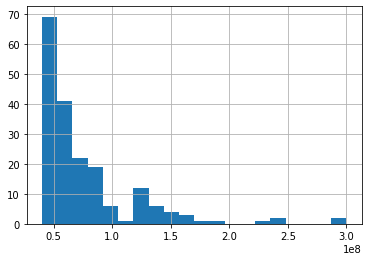

In [100]:
df['last_price'].hist(range=(40000000,300000000), bins=20);

После 40 млн рублей единичные предложения, скорее всего строго индивидуальные, где на цену влияет история места, престиж, определенный круг соседей. В нашем исследовании не стоит задачи анализа по этим характеристикам, да и самих предложений мало для анализа. Судя по графикам, мы в общем можем смело откинуть диапазон превышающий 15 млн., Это сократит датасет всего на 5% - допустимые потери для нашего анализа.

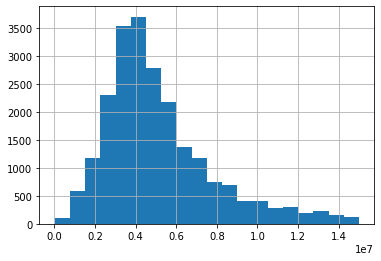

In [101]:
df = df[df['last_price'] < 15000000]
df['last_price'].hist(bins=20);

А что там за подозрительно низкие значения в начале диаграммы?

In [102]:
df.sort_values(by='last_price')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12190.0,109.0,2019-03-20T00:00:00,2,2.75,25.0,32.0,25,NaN,False,False,40.5,NaN,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0
17456,7,430000.0,30.4,2019-04-22T00:00:00,1,NaN,2.0,16.0,1,NaN,False,False,6.0,NaN,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14911,5,430000.0,54.0,2018-06-26T00:00:00,2,NaN,3.0,NaN,3,NaN,False,False,NaN,NaN,посёлок станции Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.0
16274,18,440000.0,40.0,2018-07-10T00:00:00,1,NaN,5.0,NaN,1,NaN,False,False,NaN,NaN,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45.0
16219,14,450000.0,38.5,2018-07-11T00:00:00,2,2.65,2.0,NaN,1,NaN,False,False,NaN,NaN,деревня Вахнова Кара,NaN,NaN,NaN,NaN,NaN,NaN,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6628,0,14990000.0,81.4,2017-10-23T00:00:00,2,3.70,5.0,46.9,5,NaN,False,False,15.1,NaN,Санкт-Петербург,23413.0,4195.0,0.0,NaN,0.0,NaN,295.0
17992,15,14990000.0,123.0,2016-09-06T00:00:00,3,3.10,12.0,62.0,12,NaN,False,False,28.0,NaN,Сестрорецк,57575.0,34505.0,2.0,428.0,1.0,615.0,656.0
13171,4,14998000.0,118.0,2017-08-27T00:00:00,3,2.70,23.0,50.0,3,NaN,False,False,17.0,2.0,Санкт-Петербург,40841.0,12544.0,2.0,51.0,0.0,NaN,149.0
5459,18,14999000.0,78.7,2015-01-21T00:00:00,2,3.55,5.0,40.0,2,NaN,False,False,13.6,NaN,Санкт-Петербург,25185.0,3888.0,1.0,65.0,1.0,651.0,NaN


450 000 - 500 000 р за однушку или даже за двушку где-то далеко в области - это может и нормально. Но 12 000 р. в верхней строчке за 109 м2 в Санкт-Петербурге - это ошибка. Явно недостает трех нулей на конце. Добавим их, и взглянем на наш новый идеальный столбец цен.

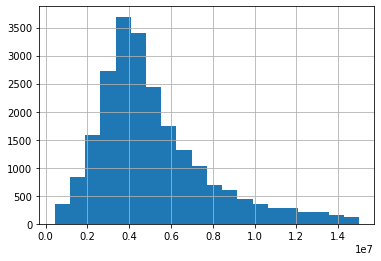

In [103]:
df['last_price'] = df['last_price'].where(df['last_price'] != 12190, 12190*1000)
df['last_price'].hist(bins=20);

In [104]:
df['last_price'].describe()

count    2.245400e+04
mean     5.144113e+06
std      2.685657e+06
min      4.300000e+05
25%      3.350000e+06
50%      4.500000e+06
75%      6.300000e+06
max      1.500000e+07
Name: last_price, dtype: float64

Да, с ценой теперь все в порядке: минимум - 450 000 р, максимум 15 млн, среднее находится на уровне 4 500 000 р, что говорит нам о том, что предложений нижнего диапазона количественно больше, чем верхнего. Эту картину мы видим и на гистограмме. Все сходится.

#### Общая площадь

На начальной гистограмме вверху колонка total_area выглядит странно. По оси Х график растянулся до площади в 800 кв.м. Но ведь мы уже очистили датасет от аномалии с ценами, может данный график был причиной тех же аномалий? Давайте снова взглянем на колонку общей площади.

In [105]:
df['total_area'].describe()

count    22454.000000
mean        55.121648
std         21.802867
min         12.000000
25%         39.400000
50%         50.105000
75%         65.675000
max        320.000000
Name: total_area, dtype: float64

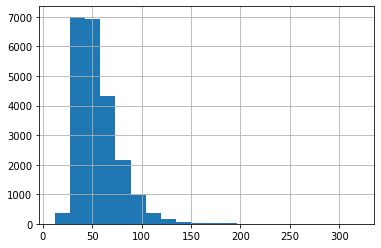

In [106]:
df['total_area'].hist(bins=20);

Выглядит приемлемо. В центре города из коммуналок действительно умудряются делать квартиры по 12 м2, со всеми удобствами и официальной пропиской. И квартиры площадью 320 м2 тоже существуют. Судя по сервису Яндекс.Недвижимости, например на Крестовском острове.

#### Количество комнат

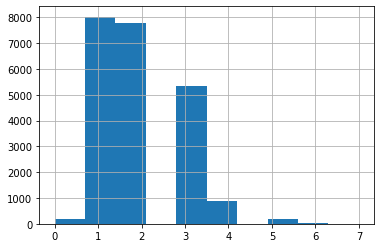

In [107]:
df['rooms'].hist();

Квартиры с нулем комнат - это студии? Проверим эту гипотезу

In [108]:
df.sort_values(by='rooms')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1220,5,3300000.0,27.00,2017-11-10T00:00:00,0,2.80,17.0,20.0,16,NaN,True,False,NaN,NaN,Санкт-Петербург,12507.0,12419.0,0.0,NaN,1.0,528.0,113.0
1260,0,2600000.0,27.00,2018-07-20T00:00:00,0,2.70,16.0,16.0,4,NaN,True,False,NaN,2.0,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,102.0
10606,14,2950000.0,25.27,2017-11-17T00:00:00,0,NaN,25.0,25.0,11,NaN,False,True,NaN,1.0,Санкт-Петербург,11405.0,13222.0,0.0,NaN,1.0,623.0,51.0
13953,21,3255000.0,28.20,2017-09-26T00:00:00,0,NaN,24.0,20.0,2,NaN,False,True,NaN,NaN,Санкт-Петербург,41466.0,11538.0,0.0,NaN,0.0,NaN,119.0
15569,2,1899400.0,23.30,2018-07-17T00:00:00,0,2.70,4.0,16.1,4,NaN,True,False,NaN,2.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039,3,13520000.0,162.80,2018-03-21T00:00:00,7,3.00,4.0,121.6,4,NaN,False,False,15.9,NaN,Санкт-Петербург,20631.0,1899.0,3.0,360.0,3.0,153.0,NaN
14603,12,13490000.0,100.60,2018-07-31T00:00:00,7,NaN,4.0,NaN,2,True,False,False,NaN,NaN,Санкт-Петербург,24309.0,3876.0,3.0,574.0,3.0,325.0,50.0
2462,18,7900000.0,201.50,2018-08-17T00:00:00,7,NaN,2.0,NaN,2,NaN,False,False,NaN,NaN,посёлок Парголово,54990.0,20665.0,0.0,NaN,0.0,NaN,35.0
13736,6,14990000.0,203.00,2017-07-03T00:00:00,7,3.66,6.0,132.0,4,NaN,False,False,14.0,NaN,Санкт-Петербург,24102.0,4670.0,1.0,443.0,0.0,NaN,NaN


Да, точно. Квартиры с маленькой площадью имеют ноль комнат. Это не аномалии, это студии. Оставляем их в нашем наборе данных. А почему график не целостный? Комнат всего может быть от 0 до 7. Уточним это количество в гистограмме

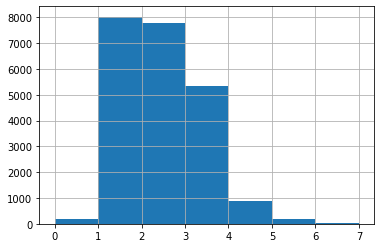

In [109]:
df['rooms'].hist(bins=7);

Отлично, никаких аномалий. С этим столбцом закончили.

#### Высота потолков

Посмотрим на распределение данных в колонке `ceiling_height`. На гистограммах выше ceiling_height по оси Х располагается от 1 до 100. Потолки высотой в 100 метров - это явно ошибка.

Интересно, какова минимальная высота потолков в Санкт-Петербурге и Ленинградской области? 

Открываем СНиП (Строительные нормы и правила) и читаем:

*Высоту потолков в многоквартирных домах стандартной застройки регламентирует п. 5.8 СНиП 31-01-2003. Согласно этому документу, высота потолка зависит от климатических условий в конкретном районе, а также от назначения и типа комнаты. В теплых зонах потолок должен располагаться на высоте не менее 2,7 метра, а для остальных районов минимальная высота потолка составляет 2,5 метра.*

Высота потолков зависит от средней температуры в регионе. Чем ниже средняя температура по региону, тем выше потолки. Санкт-Петербург относятся к климатическому району со средней температурой зимой –14…–4 °С, а летом — +12…+21 °С. По нормам в регионе с такой температурой минимальная высота потолков должна быть 2,5 метра. Значит потолков ниже этой нормы в нашем датасете быть не может. Много ли у нас таких аномалий?

In [110]:
df[df['ceiling_height'] < 2.5]['ceiling_height'].count()

73

Всего 73 квартиры с нарушением строительных норм, а скорее не с нарушением, а просто с ошибкой. Откинем эти строки.

In [111]:
df = df.drop(df[df['ceiling_height'] < 2.5].index)

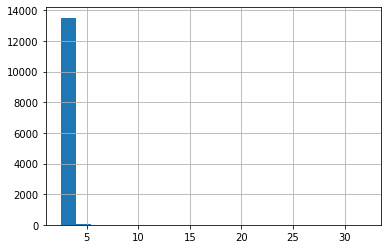

In [112]:
df['ceiling_height'].hist(bins=20);

Теперь минимум у нас 2.5 метра. Так же, Судя по графику потолки выше пяти метров - это статистический выброс отдельных единичных значений. Но перед тем, как их отпросить взглянем что там.

In [113]:
df['ceiling_height'].sort_values().unique()

array([ 2.5 ,  2.51,  2.52,  2.53,  2.54,  2.55,  2.56,  2.57,  2.58,
        2.59,  2.6 ,  2.61,  2.62,  2.63,  2.64,  2.65,  2.66,  2.67,
        2.68,  2.69,  2.7 ,  2.71,  2.72,  2.73,  2.74,  2.75,  2.76,
        2.77,  2.78,  2.79,  2.8 ,  2.81,  2.82,  2.83,  2.84,  2.85,
        2.86,  2.87,  2.88,  2.89,  2.9 ,  2.91,  2.92,  2.93,  2.94,
        2.95,  2.96,  2.97,  2.98,  2.99,  3.  ,  3.01,  3.02,  3.03,
        3.04,  3.05,  3.06,  3.07,  3.08,  3.09,  3.1 ,  3.11,  3.12,
        3.13,  3.14,  3.15,  3.16,  3.17,  3.18,  3.2 ,  3.21,  3.22,
        3.23,  3.24,  3.25,  3.26,  3.27,  3.28,  3.3 ,  3.31,  3.32,
        3.33,  3.34,  3.35,  3.36,  3.37,  3.38,  3.39,  3.4 ,  3.42,
        3.44,  3.45,  3.46,  3.47,  3.48,  3.49,  3.5 ,  3.52,  3.53,
        3.54,  3.55,  3.56,  3.57,  3.59,  3.6 ,  3.62,  3.63,  3.65,
        3.66,  3.67,  3.68,  3.7 ,  3.75,  3.78,  3.8 ,  3.83,  3.84,
        3.85,  3.88,  3.9 ,  3.93,  3.95,  3.98,  4.  ,  4.06,  4.1 ,
        4.15,  4.19,

Большинство - всего по одному значению. А что там за потолки под 20-30 метров?

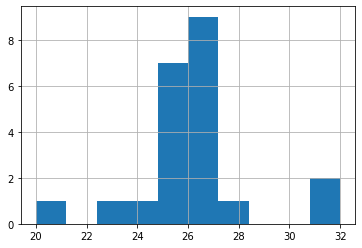

In [114]:
df['ceiling_height'].hist(range=(20,32));

Потолки выше пяти метров малочисленны и маловероятны. Их тоже можно откинуть. Такие цифры встречаются в таблице всего по одному-два раза. Однако потолки 25 - 32 метра встречаются чаще. Скорее всего это неправильно поставленная запятая. Переименуем их вручную в исходном датасете. А заодно и отрежем слишком маленькие и слишком большие значения, определенные до этого.

In [115]:
# Основные столбцы где стоит поработать с выбросами это стоимость квартиры, 
# высота потолков, количество комнат и общая площадь.
#df.info()
#df[~df['ceiling_height'].isna()]
df['ceiling_height'].unique() #describe()

array([ 2.7 ,   nan,  3.03,  2.5 ,  2.67,  2.56,  3.05,  2.75,  2.6 ,
        2.9 ,  2.8 ,  2.55,  3.  ,  2.65,  2.61,  3.2 ,  3.25,  3.45,
        2.77,  2.64,  2.57,  4.15,  4.  ,  2.73,  2.84,  3.1 ,  3.4 ,
        2.72,  2.54,  2.51,  2.78,  2.76, 25.  ,  2.58,  3.7 ,  2.52,
        3.3 ,  3.5 ,  2.66,  2.59,  2.85,  2.92,  3.11,  3.13,  3.8 ,
        3.15,  3.55,  3.62,  3.12,  2.53,  2.74,  5.  ,  2.79,  2.95,
        4.06,  2.94,  3.54,  2.83,  3.38,  3.01,  3.65,  2.71,  2.62,
        3.57,  2.82,  3.98,  2.63,  3.83,  3.52,  2.88,  3.67,  4.19,
        3.95,  3.35,  4.8 ,  4.5 ,  4.2 ,  3.75,  3.36, 32.  ,  3.68,
        3.07,  3.37,  3.09,  8.  ,  3.16,  3.6 ,  3.26,  3.34,  2.81,
        3.44,  2.97,  4.37,  2.68,  3.9 ,  3.27, 27.  ,  4.1 ,  2.93,
        3.46, 24.  ,  3.47,  3.33,  3.63,  3.14,  3.32, 26.  ,  3.18,
        8.3 ,  2.98,  3.24,  2.86,  3.08,  3.17,  3.28,  3.04,  3.66,
        3.84,  3.23,  3.02,  2.96,  3.21,  2.87,  4.3 ,  3.06,  3.39,
        2.69,  4.4 ,

In [116]:
mistaken_heights = [24, 25, 26, 27, 27.5, 32]
for height in mistaken_heights:
    df['ceiling_height'] = df['ceiling_height'].where(df['ceiling_height'] != height, height/10)
df[df['ceiling_height'] > 5]['ceiling_height'].count()    

10

Осталось всего 10 аномальных потолков. Их можно смело исключить из наших данных. Но если мы их исключим, в откинутые значения также попадут и пустые значения, а это почти половина датасета. 

Пойдем другим путем, и для начала все потолки выше 5 метров сделаем пустыми значениями.

In [117]:
df.loc[df['ceiling_height'] > 5, 'ceiling_height'] = float('nan')

Жильё эконом класса будут строить по минимальным стандартам, чтобы уложиться в бюджетную стоимость. Сегмент выше эконом может строить потолки выше, и это будет отражаться на стоимости. Исходя из этого данного мы можем распределить жилью на сегменты и примерно прикинуть, какие цифры должны стоять на месте пропущенных значений. Вычисления будут приблизительные, усредненные, однако это лучше, чем выкинуть почти 50% данных в окно и в итоге прийти к неверным заключениям.

Высота потолков может отличаться от города/округа в области. В отдельных территориальных единицах Ленинградской области заполним высоту потолков своими локальными медианами.

Посмотрим диапазон цен за квадратный метр в Санкт-Петербурге. Для этого добавим новый столбец в наш набор данных.

In [118]:
df['price_per_sqm'] = (df['last_price'] / df['total_area']).round().astype(int)
df[df['locality_name'] == 'Санкт-Петербург']['price_per_sqm'].describe()

count     14486.000000
mean     107118.232500
std       25096.073863
min       15345.000000
25%       90051.750000
50%      102778.000000
75%      120000.000000
max      387097.000000
Name: price_per_sqm, dtype: float64

В среднем квадратный метр в городе стоит от 102 до 107 тысяч рублей. Мы будем считать все что ниже 102 000 р. - эконом классом, а выше - комфорт и т.д. Расчитаем высоту подолков для этих двух диапазонов.

In [119]:
import warnings
warnings.simplefilter("ignore")

ceilings_filled_list = []
for locality, data in df.groupby('locality_name'):
    if locality != 'Санкт-Петербург':
        median = data['ceiling_height'].median()
        if median != median: # т.е. если это NaN
            median = 2.5 # Поставим минимум
        #df.loc[df['locality_name'] == locality, 'ceiling_height'] = median
        ceilings_filled_list.append(data['ceiling_height'].fillna(median))
    else:
        econom_spb = data[data['price_per_sqm'] < 102000]['ceiling_height']
        comfort_spb = data[data['price_per_sqm'] >= 102000]['ceiling_height']
        ceilings_filled_list.append(econom_spb.fillna(econom_spb.median()))
        ceilings_filled_list.append(comfort_spb.fillna(comfort_spb.median()))
        
ceilings_filled_series = pd.concat(ceilings_filled_list)
df['ceiling_height'] = ceilings_filled_series

In [120]:
df[df['ceiling_height'].isna() == True]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_sqm
1097,3,8600000.0,81.70,2016-04-15T00:00:00,3,NaN,5.0,50.8,2,NaN,False,False,8.8,0.0,NaN,23478.0,4258.0,0.0,NaN,0.0,NaN,147.0,105263
2033,6,5398000.0,80.00,2017-05-30T00:00:00,3,NaN,4.0,42.6,2,NaN,False,False,18.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0,67475
2603,20,3351765.0,42.70,2015-09-20T00:00:00,1,NaN,24.0,15.6,3,NaN,False,False,10.7,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,276.0,78496
2632,2,5130593.0,62.40,2015-10-11T00:00:00,2,NaN,24.0,33.1,21,NaN,False,False,8.2,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,256.0,82221
3574,10,4200000.0,46.50,2016-05-28T00:00:00,2,NaN,5.0,30.8,5,NaN,False,False,6.5,0.0,NaN,27419.0,8127.0,0.0,NaN,1.0,603.0,45.0,90323
4189,7,9200000.0,80.00,2015-12-10T00:00:00,3,NaN,4.0,52.3,3,False,False,False,10.4,0.0,NaN,21774.0,3039.0,1.0,690.0,1.0,953.0,223.0,115000
4670,1,5500000.0,83.00,2015-08-14T00:00:00,3,NaN,7.0,NaN,6,NaN,False,False,NaN,0.0,NaN,26534.0,5382.0,1.0,446.0,1.0,376.0,350.0,66265
5343,19,13540000.0,85.50,2016-01-20T00:00:00,3,NaN,7.0,59.1,5,False,False,False,8.3,4.0,NaN,10556.0,9538.0,1.0,67.0,0.0,NaN,303.0,158363
5707,7,3700000.0,30.00,2016-04-29T00:00:00,1,NaN,24.0,20.0,23,NaN,False,False,NaN,0.0,NaN,21460.0,16788.0,0.0,NaN,1.0,170.0,49.0,123333
6765,20,4895892.0,60.70,2015-03-12T00:00:00,2,NaN,24.0,31.9,3,NaN,False,False,12.2,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,468.0,80657


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22381 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          22381 non-null  int64  
 1   last_price            22381 non-null  float64
 2   total_area            22381 non-null  float64
 3   first_day_exposition  22381 non-null  object 
 4   rooms                 22381 non-null  int64  
 5   ceiling_height        22336 non-null  float64
 6   floors_total          22300 non-null  float64
 7   living_area           20629 non-null  float64
 8   floor                 22381 non-null  int64  
 9   is_apartment          2615 non-null   object 
 10  studio                22381 non-null  bool   
 11  open_plan             22381 non-null  bool   
 12  kitchen_area          20237 non-null  float64
 13  balcony               11586 non-null  float64
 14  locality_name         22336 non-null  object 
 15  airports_nearest   

Отлично, потолки теперь на месте, никаких аномалий.

Были бы пропуски как-то связаны с этажностью, площадью, стоимостью или хоть чем-то, то можно было бы заполнить их средними значениями по группе. Целью анализа является установить взаимосвязь, или определить, что ее нет. В данном случае у нас последнее. Оставим пока пропуски в покое. Определение стоимости квартиры от высоты потолков будем считать по имеющимся данным. Пропусков хоть и много, но все-таки меньше половины. Будем надеяться, что этих данных нам хватит.

#### Жилая прощадь

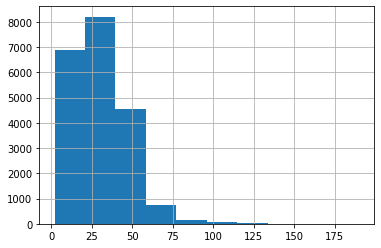

In [122]:
df['living_area'].hist();

Тут теперь тоже все хорошо

#### Этаж

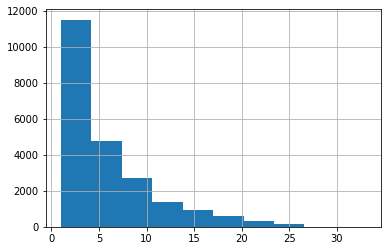

In [123]:
df['floor'].hist();

Никаких аномалий

#### Площадь кухни

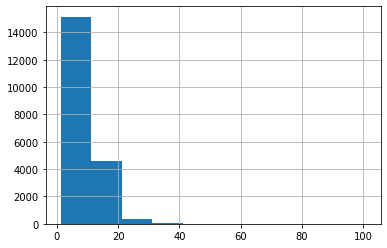

In [124]:
df['kitchen_area'].hist();

Можем оставить как есть

#### Даты размещения объявлений

Для того, чтобы работать с этой колонкой, нужно преобразовать ее формат. Данные в колонке изначально определились как строковые, а нам нужен формат `datetime`. Тогда мы сможем сравнивать даты и измерять диапазоны.

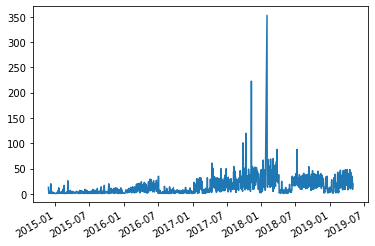

In [125]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
df['first_day_exposition'].value_counts().plot(); #hist()

Конвертация прошла без ошибок. На графике видно, что сервис со временем становится все популярнее - с годами публикуется все больше объявлений. Этот столбец тоже готов к анализу.

#### Типы данных

Мы только что изменили тип данных в колонке `first_day_exposition`. У нас есть и другие колонки, требующие подобного преобразования. Например, `floors_total` может быть только целим числом, `is_apartment` должен быть булевым, `balcony`, `parks_around3000` `ponds_around3000` и `days_exposition`- целым,

In [126]:
# Колонки 'floors_total' и 'days_exposition' содержат пропуски, которые мы не сможем заполнить. 
# Преобразуем их в целочисленный тип, который поддерживает наличие пропусков
df['floors_total'] = df['floors_total'].astype("Int64")
#df['days_exposition'] = df['days_exposition'].astype("Int64")

# В категории апартаментов много пропусков, заполним их нулями, и потом преобразуем в булевы значения
df['is_apartment'] = df['is_apartment'].fillna(0)
df['is_apartment'] = df['is_apartment'].astype(bool)

## Преобразование `balcony` в целое значение дает ошибку, потому что этот столбец содержит отсутствующие значения NaN.
# В данном случае, вполне логично допустить, что отсутствие значения означает 'нет', т.е. 0
# Значит можем заполнить нулями все отсутствующие значения
df['balcony'] = df['balcony'].fillna(0)
df['balcony'] = df['balcony'].astype(int)

# То же самое и с парками и озерами
df['parks_around3000'] = df['parks_around3000'].fillna(0)
df['parks_around3000'] = df['parks_around3000'].astype(int)

df['ponds_around3000'] = df['ponds_around3000'].fillna(0)
df['ponds_around3000'] = df['ponds_around3000'].astype(int)

Колонки с вещественными числами представлены в формате float64. Этот формат предоставляет большую точность 
данных (знаков после запятой), но и занимает больше памяти, а значит и медленнее обрабатывается. В данном исследовании максимальная точность, которая может нам понадобиться - это сотые части (два знака после запятой), так что для нашей задачи float64 будет избыточным. Преобразуем эти колонки в float32


In [127]:
for column in df.columns:
    if df[column].dtype == 'float64':
        df[column] = df[column].astype('float32')

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22381 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22381 non-null  int64         
 1   last_price            22381 non-null  float32       
 2   total_area            22381 non-null  float32       
 3   first_day_exposition  22381 non-null  datetime64[ns]
 4   rooms                 22381 non-null  int64         
 5   ceiling_height        22336 non-null  float32       
 6   floors_total          22300 non-null  Int64         
 7   living_area           20629 non-null  float32       
 8   floor                 22381 non-null  int64         
 9   is_apartment          22381 non-null  bool          
 10  studio                22381 non-null  bool          
 11  open_plan             22381 non-null  bool          
 12  kitchen_area          20237 non-null  float32       
 13  balcony         

#### Категории значений

Давайте еще раз взглянем на столбцы таблицы. Мы разобрались с целыми и вещественными значениями в столбцах. Остальные типы столбцов - категориальные. Булевы значения у нас под контролем, нужно теперь проверить уникальность категорий в строковых столбцах. Такой столбец у нас остался один - `locality_name`

In [129]:
# Сначала проверим пустые значения
df[df['locality_name'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_sqm
1097,3,8600000.0,81.699997,2016-04-15,3,NaN,5,50.799999,2,False,False,False,8.800000,0,NaN,23478.0,4258.0,0,NaN,0,NaN,147.0,105263
2033,6,5398000.0,80.000000,2017-05-30,3,NaN,4,42.599998,2,False,False,False,18.600000,0,NaN,NaN,NaN,0,NaN,0,NaN,34.0,67475
2603,20,3351765.0,42.700001,2015-09-20,1,NaN,24,15.600000,3,False,False,False,10.700000,0,NaN,22041.0,17369.0,0,NaN,1,374.0,276.0,78496
2632,2,5130593.0,62.400002,2015-10-11,2,NaN,24,33.099998,21,False,False,False,8.200000,0,NaN,22041.0,17369.0,0,NaN,1,374.0,256.0,82221
3574,10,4200000.0,46.500000,2016-05-28,2,NaN,5,30.799999,5,False,False,False,6.500000,0,NaN,27419.0,8127.0,0,NaN,1,603.0,45.0,90323
4189,7,9200000.0,80.000000,2015-12-10,3,NaN,4,52.299999,3,False,False,False,10.400000,0,NaN,21774.0,3039.0,1,690.0,1,953.0,223.0,115000
4670,1,5500000.0,83.000000,2015-08-14,3,NaN,7,NaN,6,False,False,False,NaN,0,NaN,26534.0,5382.0,1,446.0,1,376.0,350.0,66265
5343,19,13540000.0,85.500000,2016-01-20,3,NaN,7,59.099998,5,False,False,False,8.300000,4,NaN,10556.0,9538.0,1,67.0,0,NaN,303.0,158363
5707,7,3700000.0,30.000000,2016-04-29,1,NaN,24,20.000000,23,False,False,False,NaN,0,NaN,21460.0,16788.0,0,NaN,1,170.0,49.0,123333
6765,20,4895892.0,60.700001,2015-03-12,2,NaN,24,31.900000,3,False,False,False,12.200000,0,NaN,22041.0,17369.0,0,NaN,1,374.0,468.0,80657


Таких значений всего 12, и ,судя по ценам, это однозначно Санкт-Петербург, населенный пункт не указали, потому что "и так понятно".

In [130]:
df['locality_name'] = df['locality_name'].fillna('Санкт-Петербург')

In [131]:
print(df['locality_name'].sort_values().unique())
print(df['locality_name'].nunique())

['Бокситогорск' 'Волосово' 'Волхов' 'Всеволожск' 'Выборг' 'Высоцк'
 'Гатчина' 'Зеленогорск' 'Ивангород' 'Каменногорск' 'Кингисепп' 'Кириши'
 'Кировск' 'Колпино' 'Коммунар' 'Красное Село' 'Кронштадт' 'Кудрово'
 'Лодейное Поле' 'Ломоносов' 'Луга' 'Любань' 'Мурино' 'Никольское'
 'Новая Ладога' 'Отрадное' 'Павловск' 'Петергоф' 'Пикалёво' 'Подпорожье'
 'Приморск' 'Приозерск' 'Пушкин' 'Санкт-Петербург' 'Светогорск'
 'Сертолово' 'Сестрорецк' 'Сланцы' 'Сосновый Бор' 'Сясьстрой' 'Тихвин'
 'Тосно' 'Шлиссельбург' 'городской поселок Большая Ижора'
 'городской поселок Янино-1' 'городской посёлок Будогощь'
 'городской посёлок Виллози' 'городской посёлок Лесогорский'
 'городской посёлок Мга' 'городской посёлок Назия'
 'городской посёлок Новоселье' 'городской посёлок Павлово'
 'городской посёлок Рощино' 'городской посёлок Советский'
 'городской посёлок Фёдоровское' 'городской посёлок Янино-1'
 'деревня Агалатово' 'деревня Аро' 'деревня Батово' 'деревня Бегуницы'
 'деревня Белогорка' 'деревня Большая В

Теперь пустых значений в списке нет. Следующим шагом унифицируем написание е и ё. Это первые дубликаты, которые бросаются в глаза Как пишут чаще?

In [132]:
print('Поселок', df['locality_name'].str.contains('поселок').sum())
print('Посёлок', df['locality_name'].str.contains('посёлок').sum())

Поселок 550
Посёлок 2097


Написание с ё более распространено, а значит и в будущем придется исправлять меньше, если возьмем этот вариант.

In [133]:
df['locality_name'] = df['locality_name'].str.replace('поселок', 'посёлок')
print(df['locality_name'].sort_values().unique())
print(df['locality_name'].nunique())

['Бокситогорск' 'Волосово' 'Волхов' 'Всеволожск' 'Выборг' 'Высоцк'
 'Гатчина' 'Зеленогорск' 'Ивангород' 'Каменногорск' 'Кингисепп' 'Кириши'
 'Кировск' 'Колпино' 'Коммунар' 'Красное Село' 'Кронштадт' 'Кудрово'
 'Лодейное Поле' 'Ломоносов' 'Луга' 'Любань' 'Мурино' 'Никольское'
 'Новая Ладога' 'Отрадное' 'Павловск' 'Петергоф' 'Пикалёво' 'Подпорожье'
 'Приморск' 'Приозерск' 'Пушкин' 'Санкт-Петербург' 'Светогорск'
 'Сертолово' 'Сестрорецк' 'Сланцы' 'Сосновый Бор' 'Сясьстрой' 'Тихвин'
 'Тосно' 'Шлиссельбург' 'городской посёлок Большая Ижора'
 'городской посёлок Будогощь' 'городской посёлок Виллози'
 'городской посёлок Лесогорский' 'городской посёлок Мга'
 'городской посёлок Назия' 'городской посёлок Новоселье'
 'городской посёлок Павлово' 'городской посёлок Рощино'
 'городской посёлок Советский' 'городской посёлок Фёдоровское'
 'городской посёлок Янино-1' 'деревня Агалатово' 'деревня Аро'
 'деревня Батово' 'деревня Бегуницы' 'деревня Белогорка'
 'деревня Большая Вруда' 'деревня Большая Пусто

На 25 категорий меньше. Теперь видны дубликаты "городской посёлок" и "посёлок городского типа". Исправим и это.

In [134]:
print('городской посёлок', df['locality_name'].str.contains('городской посёлок').sum())
print('посёлок городского типа', df['locality_name'].str.contains('посёлок городского типа').sum())

городской посёлок 185
посёлок городского типа 361


In [135]:
df['locality_name'] = df['locality_name'].str.replace('городской посёлок', 'посёлок городского типа')
print(df['locality_name'].sort_values().unique())
print(df['locality_name'].nunique())

['Бокситогорск' 'Волосово' 'Волхов' 'Всеволожск' 'Выборг' 'Высоцк'
 'Гатчина' 'Зеленогорск' 'Ивангород' 'Каменногорск' 'Кингисепп' 'Кириши'
 'Кировск' 'Колпино' 'Коммунар' 'Красное Село' 'Кронштадт' 'Кудрово'
 'Лодейное Поле' 'Ломоносов' 'Луга' 'Любань' 'Мурино' 'Никольское'
 'Новая Ладога' 'Отрадное' 'Павловск' 'Петергоф' 'Пикалёво' 'Подпорожье'
 'Приморск' 'Приозерск' 'Пушкин' 'Санкт-Петербург' 'Светогорск'
 'Сертолово' 'Сестрорецк' 'Сланцы' 'Сосновый Бор' 'Сясьстрой' 'Тихвин'
 'Тосно' 'Шлиссельбург' 'деревня Агалатово' 'деревня Аро' 'деревня Батово'
 'деревня Бегуницы' 'деревня Белогорка' 'деревня Большая Вруда'
 'деревня Большая Пустомержа' 'деревня Большие Колпаны'
 'деревня Большое Рейзино' 'деревня Большой Сабск' 'деревня Бор'
 'деревня Борисова Грива' 'деревня Ваганово' 'деревня Вартемяги'
 'деревня Вахнова Кара' 'деревня Выскатка' 'деревня Гарболово'
 'деревня Глинка' 'деревня Горбунки' 'деревня Гостилицы'
 'деревня Заклинье' 'деревня Заневка' 'деревня Зимитицы' 'деревня Извар

Еще минус четыре дубликата. Дело сделано, больше дубликатов нет. И это конец нашего этапа подготовки данных!

**Вывод:** мы смогли заполнить отсутствующие значения в колонках, определились с наличием балконов, исправили некоторые цены, скорректировали высоту потолков, исправили неявные дубликаты в категориях. Теперь все необходимые для нашего анализа колонки с данными имеют форму нормального распределения, а значит готовы для анализа.

In [136]:
df.shape[0] / df_original.shape[0]

0.9443858390649394

### Добавим в таблицу новые столбцы

Мы уже добавили в таблицу новый столбец со стоимостью за квадратный метро. Для того, чтобы провести анализ, нам потребуются дополнительные столбцы:
- стоимость за квадратный метр,
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее),
- месяц публикации объявления,
- год публикации объявления,
- тип этажа квартиры (значения — «первый», «последний», «другой»),
- расстояние до центра города в километрах

In [137]:
df['pub_weekday'] = df['first_day_exposition'].dt.weekday
df['pub_month'] = df['first_day_exposition'].dt.month
df['pub_year'] = df['first_day_exposition'].dt.year

Все идет хорошо, но при разбиении этажей на категории возникла ошибка из-за пропущенных значений. Взглянем на них.

In [138]:
df[df['floors_total'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_sqm,pub_weekday,pub_month,pub_year
186,12,11640000.0,65.199997,2018-10-02,2,2.7,<NA>,30.799999,4,False,False,False,12.000000,0,Санкт-Петербург,39197.0,12373.0,1,123.0,0,NaN,49.0,178528,1,10,2018
237,4,2438033.0,28.100000,2016-11-23,1,2.6,<NA>,20.750000,1,False,False,False,NaN,0,Санкт-Петербург,22041.0,17369.0,0,NaN,1,374.0,251.0,86763,2,11,2016
457,4,9788348.0,70.800003,2015-08-01,2,2.7,<NA>,38.400002,12,False,False,False,10.630000,0,Санкт-Петербург,37364.0,8322.0,2,309.0,2,706.0,727.0,138254,5,8,2015
671,4,6051191.0,93.599998,2017-04-06,3,2.6,<NA>,47.099998,8,False,False,False,16.799999,0,Санкт-Петербург,22041.0,17369.0,0,NaN,1,374.0,123.0,64649,3,4,2017
1757,5,3600000.0,39.000000,2017-04-22,1,2.6,<NA>,NaN,9,False,False,False,NaN,0,Санкт-Петербург,22735.0,11618.0,1,835.0,1,652.0,77.0,92308,5,4,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21753,7,6800000.0,57.000000,2017-05-01,2,2.7,<NA>,NaN,21,False,False,False,NaN,0,Санкт-Петербург,17618.0,14600.0,2,104.0,0,NaN,36.0,119298,0,5,2017
22542,5,8500000.0,63.500000,2017-05-24,2,2.8,<NA>,NaN,3,False,False,False,NaN,0,Санкт-Петербург,51340.0,15363.0,0,NaN,1,853.0,512.0,133858,2,5,2017
22656,4,4574160.0,64.500000,2017-04-02,2,2.6,<NA>,31.700001,20,False,False,False,14.400000,0,Санкт-Петербург,22041.0,17369.0,0,NaN,1,374.0,127.0,70917,6,4,2017
22808,0,14569263.0,110.400002,2016-11-20,3,2.7,<NA>,45.380001,6,False,False,False,23.420000,0,Санкт-Петербург,19095.0,4529.0,0,NaN,0,NaN,260.0,131968,6,11,2016


Всего 80 строк. Придется их откинуть, это небольшая потеря.

In [139]:
df = df.dropna(subset=['floors_total'])

In [140]:
# Здесь нам потребуется собственная функция
def floor_cat(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

df['floor_category'] = df.apply(floor_cat, axis=1)

In [141]:
df['downtown_distance_km'] = (df['cityCenters_nearest'] / 1000).round()
#df['downtown_distance_km'] = df['downtown_distance_km'].astype("int64")
df

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_sqm,pub_weekday,pub_month,pub_year,floor_category,downtown_distance_km
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.000000,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370,3,3,2019,другой,16.0
1,7,3350000.0,40.400002,2018-12-04,1,2.63,11,18.600000,1,False,False,False,11.000000,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82921,1,12,2018,первый,19.0
2,10,5196000.0,56.000000,2015-08-20,2,2.60,5,34.299999,4,False,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92786,3,8,2015,другой,14.0
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,False,False,41.000000,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000,1,6,2018,другой,8.0
5,10,2890000.0,30.400000,2018-09-10,1,2.60,12,14.400000,5,False,False,False,9.100000,0,посёлок городского типа Янино-1,NaN,NaN,0,NaN,0,NaN,55.0,95066,0,9,2018,другой,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.809998,2017-03-21,3,3.70,5,73.300003,3,False,False,False,13.830000,0,Санкт-Петербург,24665.0,4232.0,1,796.0,3,381.0,NaN,72491,1,3,2017,другой,4.0
23695,14,3100000.0,59.000000,2018-01-15,3,2.50,5,38.000000,4,False,False,False,8.500000,0,Тосно,NaN,NaN,0,NaN,0,NaN,45.0,52542,0,1,2018,другой,NaN
23696,18,2500000.0,56.700001,2018-02-11,2,2.50,3,29.700001,1,False,False,False,NaN,0,село Рождествено,NaN,NaN,0,NaN,0,NaN,NaN,44092,6,2,2018,первый,NaN
23697,13,11475000.0,76.750000,2017-03-28,2,3.00,17,NaN,12,False,False,False,23.299999,2,Санкт-Петербург,39140.0,10364.0,2,173.0,3,196.0,602.0,149511,1,3,2017,другой,10.0


**Вывод**

Мы добавили 6 дополнительных колонок в конец нашего датасета. Это чуть увеличило его размер, но с этими данными анализ пойдет быстрее и проще, нежели мы бы вычисляли эти параметры каждый раз на лету для каждого отдельного расчета. В следующей секции воспользуемся этими колонками.

### Проведём исследовательский анализ данных

#### Что имеем на входе

Перепроверим получившуюся информацию и сделаем первые выводы

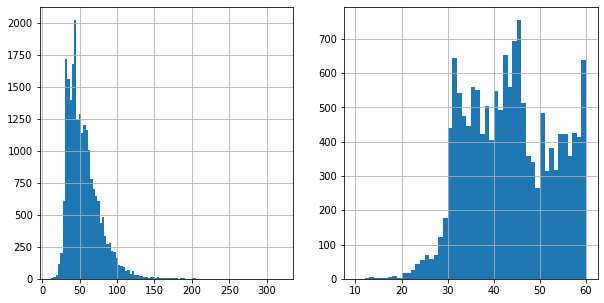

In [142]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
df['total_area'].hist(bins=100, ax=ax1, figsize=(10,5));
df['total_area'].hist(range=(10,60), bins=50, ax=ax2, figsize=(10,5));

Гистограмма общей площади объекта имеет форму нормального распределения. На графике видно, что самые "ходовые" квартиры имеют площадь в 30-60 метров. Т.е. это студии, однокомнатные и двухкомнатные квартиры.

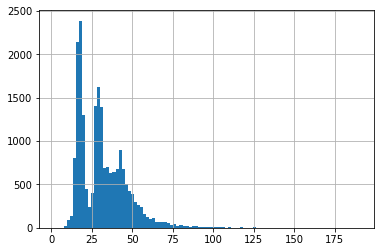

In [143]:
df['living_area'].hist(bins=100);

На графике жилой площади тоже видим эти три пика: ультра-маленькие студии меньше 25 метров, студии и однокомнатные выше 25 и двухкомнатные, вероятно с большой кухней и другими общими помещениями.

21

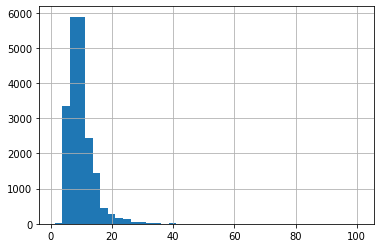

In [144]:
df['kitchen_area'].hist(bins=40);
df[df['kitchen_area'] > 40]['kitchen_area'].count()

Судя по графику площади кухни, после 40 метров всего 21 предложение, но на графике эта зона занимает больше 50%. Удаление такого значительного количества данных должно помочь значительно прояснить картину.

In [145]:
print("Кол-во строк:", df.shape[0])
df.drop(df[df['kitchen_area'] > 40].index, inplace=True)
print("Кол-во строк:", df.shape[0])

Кол-во строк: 22300
Кол-во строк: 22279


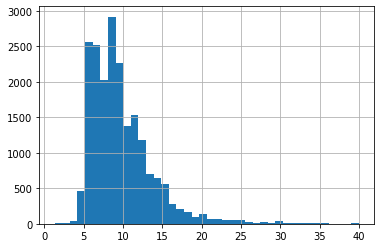

In [146]:
df['kitchen_area'].hist(bins=40);

Мы убрали выброс, который мог бы повлиять на дальнейшее исследование. Теперь наш диапазон кухонь располагается от микро-кухонь в 3-5 метров и до огромных гостиных пространств в квартирах большой площади.

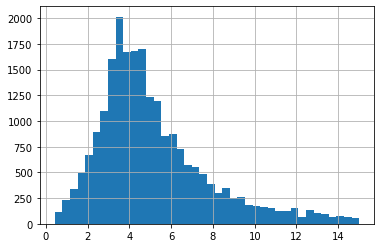

In [147]:
(df['last_price']/1000000).hist(bins=40);

Цена имеет нормальное распределение, с затуханием к концам графика. Видим, что самые распространенный диапазон - 3-5 миллионов рублей.

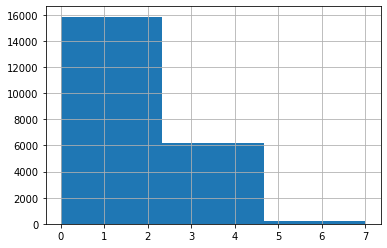

In [148]:
df['rooms'].hist(bins = data['rooms'].max());

Видно, что наибольшую распространенность имеют однокомнатные квартиры, чуть менее - двухкомнатные. В целом, картина не имеет аномалий. Однако, так как данные обрываются 2019 годом, можем предположить, что сейчас картина чуть изменилась и первый столбец будет выше, так как популярность студий растет.

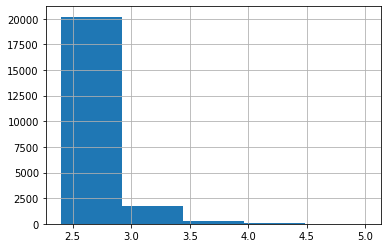

In [149]:
df['ceiling_height'].hist(bins=5);

Высота потолков начинается с минимально-допустимого строительными нормами значения - 2.5 метров. И это самое распространенное значение. Потолки выше трех метров являются редкостью.

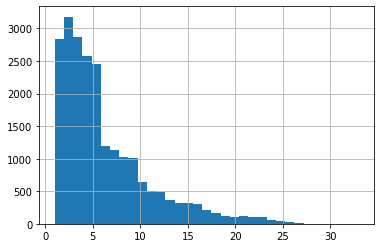

In [150]:
df['floor'].hist(bins=33);

Видим, что большинство предложений - это нижние этажи. Скорее всего первый-второй этаж продается хуже, чем другие. Запомним эту гипотезу, чтобы проверить ее позже. На графике четко видны сектора этажности - больше всего предложений о пятиэтажках, далее идут девятиэтажки. Доля более высоких домов представлена в наименьшем количестве.

другой       16359
последний     3089
первый        2831
Name: floor_category, dtype: int64


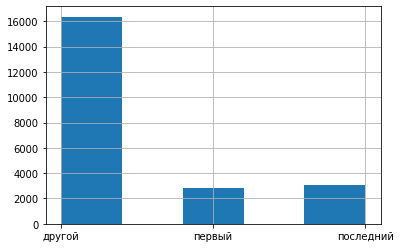

In [151]:
print(df['floor_category'].value_counts())
df['floor_category'].hist(bins=5);

Чисто статистически, в этом столбце этажи разбиты на неравные категории. Например, если мы возьмем продажи в новостройках, где сразу на продажу выставляется много квартиры, количество первых и последних этажей равно количеству построек, а вот количество средних этажей намного выше. Эту разбалансированность категорий и видим на графике. Делаем вывод, что график построен правильно. И возможно он пригодиться нам для дальнейшего исследования.

31

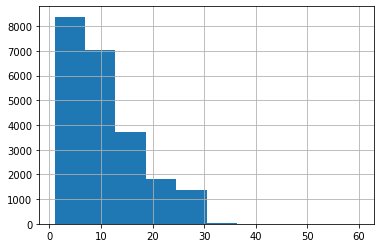

In [152]:
df['floors_total'].hist(bins=10);
(df['floors_total'] > 30).sum()

31 объект с указанной этажностью выше 30 (а точнее 27 этажей). И эта аномалия занимает половину графика. Не будем рыться в столь маленьком количестве данных. Посмотрим, как это будет без них.

In [153]:
print("Кол-во строк:", df.shape[0])
df.drop(df[df['floors_total'] > 27].index, inplace=True)
print("Кол-во строк:", df.shape[0])

Кол-во строк: 22279
Кол-во строк: 22226


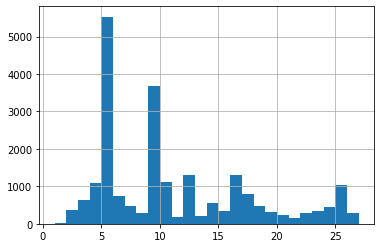

In [154]:
df['floors_total'].hist(bins=26);

Снова видим много пятиэтажек и девятиэтажек. Есть шестнадцатиэтажки, так называемые точки. И есть около 1 000 предложений в новых современных 25-этажках, такие стали строить недавно.

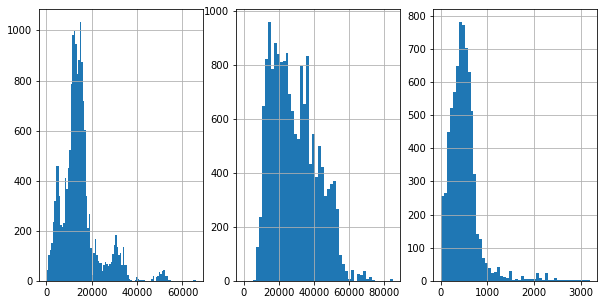

In [155]:
fig = plt.figure()
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
df['cityCenters_nearest'].hist(bins=100, ax=ax1, figsize=(10,5));
df['airports_nearest'].hist(bins=50, ax=ax2, figsize=(10,5));
df['parks_nearest'].hist(bins=50, ax=ax3, figsize=(10,5));

Относительно расположения объектов:

1. На первом графике видно, что квартир на продажу близко к центру меньше, и существует определенная зона удаления в диапазоне приблизительно 15 км, где сконцентрировано наибольшее кол-во объектов

2. Приблизительно такая же ситуация и с удаленностью от аэропорта на втором графике. В радиусе первых километров предложений нет - там, вероятно, строить нельзя. Далее отступив 15-20 км начинается зона наибольшего количества продающихся объектов.

3. Третий график - это удаленность предлагаемых объектов от городских парков. Парков в Санкт-Петербурге много, как в центре, так и на окраинах. Средняя удаленность составляет объекта недвижимости от одного из них составляет 600 метров.

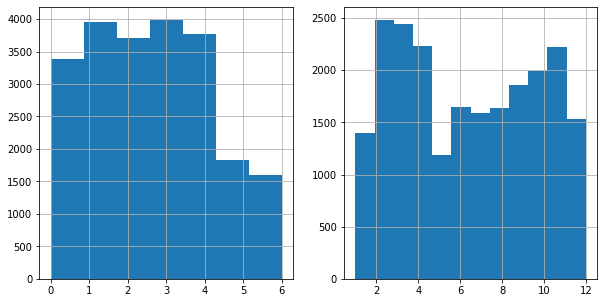

In [156]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
df['pub_weekday'].hist(bins=7, ax=ax1, figsize=(10,5));
df['pub_month'].hist(bins=12, ax=ax2, figsize=(10,5));

На графиках даты публикации видим:

1. На левом графике отчетливо видно, что объявления публикуют преимущественно по рабочим дням, в выходные количество публикаций падает в два раза.

2. Правый график представляет разбивку дат публикации по месяцам, и показывает, что объявлений публикуется больше с февраля по апрель, затем летом количество размещаемых объявлений резко падает и к концу года снова начинает постепенно увеличиваться.

**Вывод:**

Мы еще раз просмотрели отфильтрованные диаграммы и все-таки нашли дополнительные аномалии на графиках, которые теперь устранены. Теперь мы видим, что наибольшее количество предложений представляют собой квартиры 30-40 метров общей площадью, 20-30 метров жилой площади, порядка 10 метров кухней и ценой в 4-5 миллионов рублей. Обычная высота потолков порядка 2.6 метра. Больше всего предложений в пятиэтажках, второе место занимают девятиэтажки и за ними идут 16-ти этажные высотные дома. Удаление большинства объектов - 10-20 км до центра города, в среднем около 600 метров до ближайшего парка и водоёма. По сезонности можно сказать, что зимой (декабрь, январь и февраль) публикуется больше всего объявлений о продаже.

#### Как быстро продавались квартиры

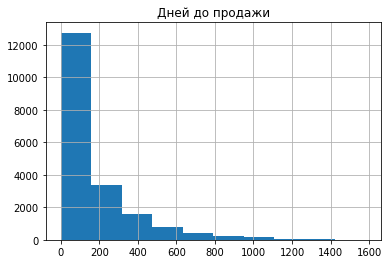

In [157]:
plt.title('Дней до продажи')
df['days_exposition'].hist();

In [158]:
df['days_exposition'].describe()

count    19445.000000
mean       176.152527
std        214.917328
min          1.000000
25%         44.000000
50%         93.000000
75%        224.000000
max       1580.000000
Name: days_exposition, dtype: float64

Большинство квартир продавались в первые полгода с момента публикации объявления. Нормальные сроки продажи от 44 до 237 дней. Максимальный срок был чуть ли не пять лет, но долгие сроки - это можно больше отнести к исключениям, так как значение медианы, устойчивой к этим выбросам, дает среднее значение в 99 дней.

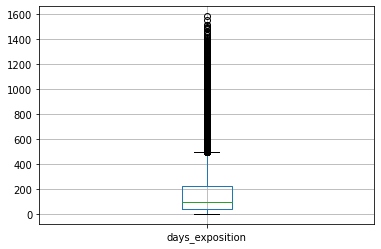

In [159]:
df.boxplot(column='days_exposition');

На основании диаграммы размаха, приемлемое время продажи простирается вплоть до 550 дней.

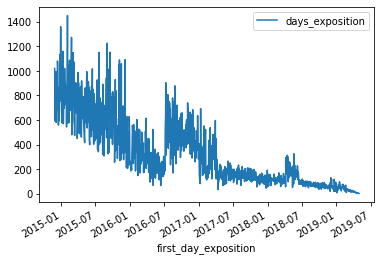

In [160]:
df.pivot_table(index='first_day_exposition', values='days_exposition').plot();

По динамике скорости продажи квартир видим, что средний срок продажи падал вплоть до кризиса 2016 года, скачок доллара в то время более чем в два раза откинул среднее время продажи где-то на год назад, но скорость продажи быстро вернулась обратно, и с 2018 года держится в среднем на уровне 100-200 дней.

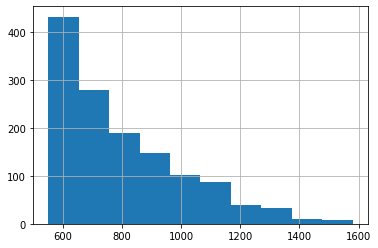

In [161]:
df[df['days_exposition'] > 550]['days_exposition'].hist();

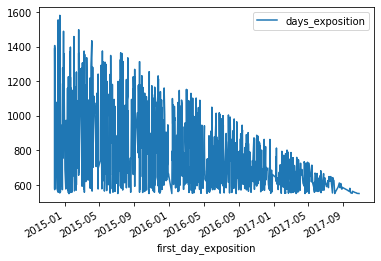

In [162]:
df[df['days_exposition'] > 550].plot(x='first_day_exposition', y='days_exposition');

Квартиры, которые продавались необычно долго (мы определили эту границу по диаграмме размаха в 550 дней) в первые два года существования сервиса. Ситуация с длительными продажами сошла на нет в сентябре 2017, что вероятно обусловлено ростом популярности сервиса Яндекс.Недвижимость и оживление рынка недвижимости после кризиса.

Напоследок мы перебрали вручную взаимосвязь всех параметров объектов с длительностью их продажи и нашли три коррелирующие связи.

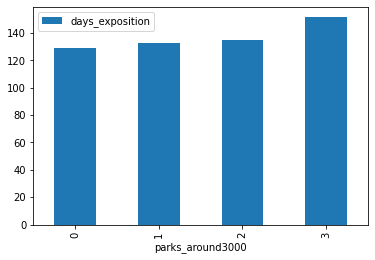

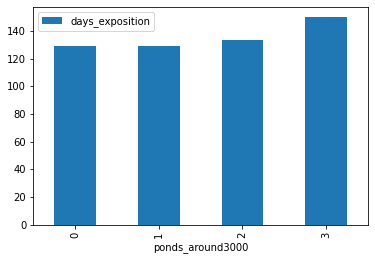

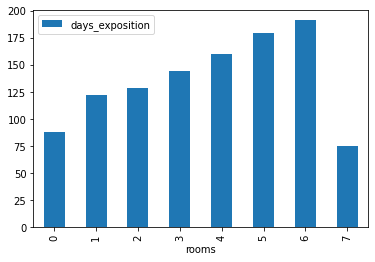

In [163]:
df[df['days_exposition'] < 550].pivot_table(index='parks_around3000', values='days_exposition').plot(kind='bar');
df[df['days_exposition'] < 550].pivot_table(index='ponds_around3000', values='days_exposition').plot(kind='bar');
df[df['days_exposition'] < 550].pivot_table(index='rooms', values='days_exposition').plot(kind='bar');

Квартиры с большим количеством парков и водоёмов продаются чуть длиннее. Скорее всего, это связано с тем, что парки сдерживают развитие другой инфраструктуры, такие объекты дальше от метро, там меньше магазинов, детских садов и школ. И из-за этого спрос на такие объекты чуть ниже.

А на последнем графике видна явная тенденция - чем больше комнат, тем квартиры продаются медленнее. По нижней границе установленного нами приемлемого диапазона (т.е. быстрее всего) продать можно студию, 5-6 комнатная квартира будет жать своих хозяев дольше, чуть выше среднего срока, и в два раза выше срока установленного медианой.

#### Факторы влияющие на стоимость объектов

Далее мы рассмотрим, какие факторы больше всего влияют на стоимость объектов недвижимости. Проверять будем 
- общую площадь,
- жилую площадь,
- площадь кухни,
- количество комнат,
- этаж, на котором расположена квартира (первый, последний, другой),
- даты размещения объявлений (день недели, месяц, год).

Коэффициент Пирсона: 0.7423907008643074


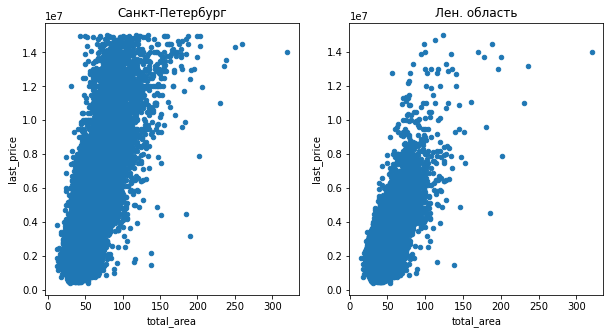

In [164]:
price_factors = ['total_area', 'living_area', 'kitchen_area', 'rooms', 
                 'pub_weekday', 'pub_month','pub_year'] #'floor_category',
price_factors_share = []

print('Коэффициент Пирсона:', df['last_price'].corr(df['total_area']))
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
df.plot(x='total_area', y='last_price', kind='scatter', figsize=(10,5), ax=ax1, title='Санкт-Петербург');
df[df['locality_name'] != 'Санкт-Петербург'].plot(x='total_area', y='last_price', kind='scatter', 
                                                  figsize=(10,5), ax=ax2, title='Лен. область');


Влияние фактора общей площади на стоимость квартиры довольно тесная. Фактически по шкале Пирсона (по коэффициенту корреляции) составляет 75%. Несмотря на разброс данных на графике, восходящая тенденция четко видна. Как в Санкт-Петербурге, так и за его пределами, по всей Ленинградской области.

Коэффициент Пирсона: 0.6354517885467246


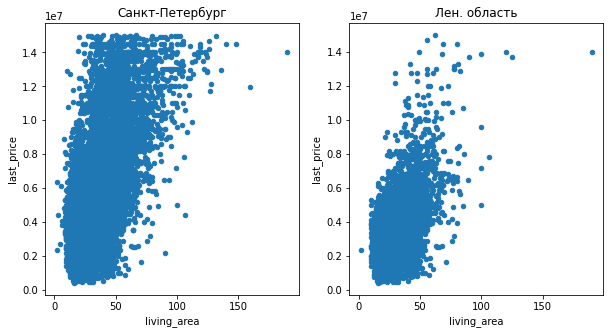

In [165]:
print('Коэффициент Пирсона:', df['last_price'].corr(df['living_area']))
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
df.plot(x='living_area', y='last_price', kind='scatter', figsize=(10,5), ax=ax1, title='Санкт-Петербург');
df[df['locality_name'] != 'Санкт-Петербург'].plot(x='living_area', y='last_price', kind='scatter', 
                                                  figsize=(10,5), ax=ax2, title='Лен. область');


Влияние количества жилой площади на стоимость объекта на 10% меньше.

Коэффициент Пирсона: 0.5412960066193349


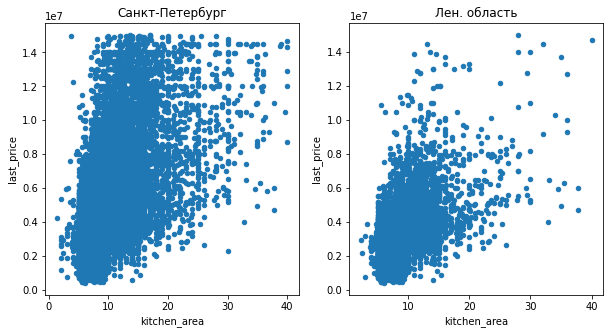

In [166]:
print('Коэффициент Пирсона:', df['last_price'].corr(df['kitchen_area']))
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
df.plot(x='kitchen_area', y='last_price', kind='scatter', figsize=(10,5), ax=ax1, title='Санкт-Петербург');
df[df['locality_name'] != 'Санкт-Петербург'].plot(x='kitchen_area', y='last_price', kind='scatter', 
                                                  figsize=(10,5), ax=ax2, title='Лен. область');


Влияние размера кухни на стоимость объекта еще на 10% меньше.

Коэффициент Пирсона: 0.49129521396498166


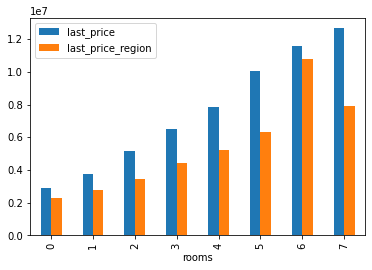

In [167]:
print('Коэффициент Пирсона:', df['last_price'].corr(df['rooms']))

df_rooms = df.pivot_table(index='rooms', values='last_price');
df_rooms['last_price_region'] = df[df['locality_name'] != 'Санкт-Петербург']\
    .pivot_table(index='rooms',values='last_price');

df_rooms.plot(kind='bar');


Конечно же, чем больше комнат, тем выше цена (пусть даже в области шести и семи комнатные квартиры не пользуются спросом). Однако индекс влияния ниже, что означает что этот параметр изменяют цену меньше, чем предыдущие.

Коэффициент Пирсона: 0.1064406390800448


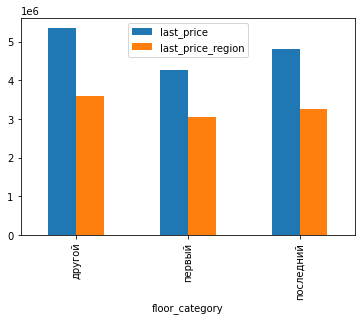

In [168]:
print('Коэффициент Пирсона:', df['last_price'].corr(df['floor']))

df_floor_category = df.pivot_table(index='floor_category', values='last_price')
df_floor_category['last_price_region'] = df[df['locality_name'] != 'Санкт-Петербург']\
    .pivot_table(index='floor_category',values='last_price');
df_floor_category.plot(kind='bar');

Первый и последний этажи менее популярны как в самом Санкт-Петербурге, так и в области. Крайние этажи статистически ниже в цене.

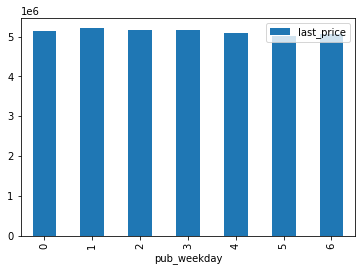

In [169]:
df_floor_category = df.pivot_table(index='pub_weekday', values='last_price')
df_floor_category.plot(kind='bar');

Цена от дня недели практически не зависит. Но возможно покупки происходят по определенным дням недели, давайте проверим эту гипотезу.

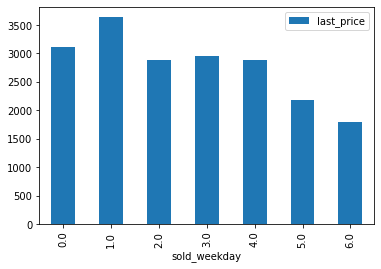

In [170]:
df['sold_weekday'] = (df['first_day_exposition'] + pd.to_timedelta(df['days_exposition'], unit='d')).dt.weekday

df_floor_category = df.pivot_table(index='sold_weekday', values='last_price', aggfunc='count')
df_floor_category.plot(kind='bar');

А вот продаж больше всего по вторникам и меньше всего в выходные.

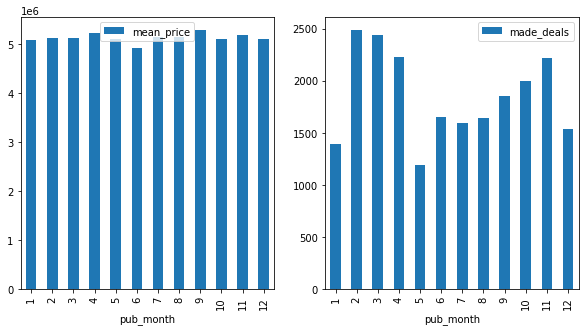

In [171]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df_floor_category = df.pivot_table(index='pub_month', values='last_price', aggfunc=['mean', 'count'])
df_floor_category.columns = ['mean_price', 'made_deals']
df_floor_category.plot(kind='bar', y='mean_price', ax=ax1, figsize=(10,5));
df_floor_category.plot(kind='bar', y='made_deals', ax=ax2, figsize=(10,5));


Можем смело сказать, что цена не зависит от месяца публикации объявления. А вот продажи объектов чаще всего происходят в период февраль-март.

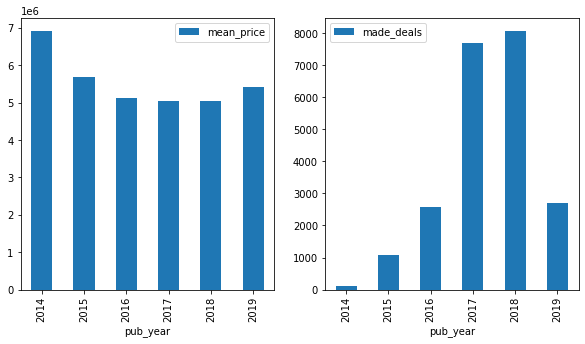

In [172]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df_floor_category = df.pivot_table(index='pub_year', values='last_price', aggfunc=['mean', 'count'])
df_floor_category.columns = ['mean_price', 'made_deals']
df_floor_category.plot(kind='bar', y='mean_price', ax=ax1, figsize=(10,5));
df_floor_category.plot(kind='bar', y='made_deals', ax=ax2, figsize=(10,5));


Средняя цена объявления упала, а сделок с годами стало заключаться все больше.

#### Средняя цена квадратного метра

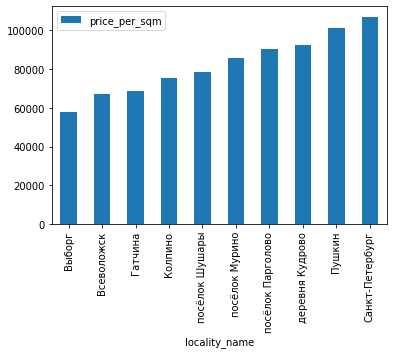

In [173]:
top_localities = df['locality_name'].value_counts()[:10].index
df_top_localities = df[df['locality_name'].isin(top_localities)]
#df_top_localities.pivot_table(index='locality_name', values='price_per_sqm').sort_values(by='price_per_sqm').plot(kind='bar')
df_top_localities.pivot_table(index='locality_name', values='price_per_sqm').sort_values(by='price_per_sqm').plot(kind='bar');

Ожидаемо, в культурной столице цена квадратного метра выше, чем по области. Недвижимость в Выборге самая доступная из десяти.

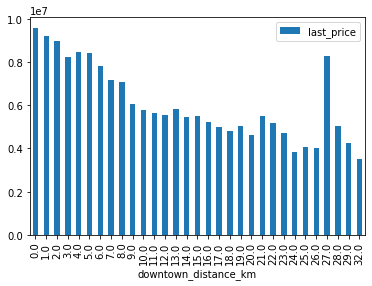

In [174]:
df[df['locality_name'] == 'Санкт-Петербург'].pivot_table(index='downtown_distance_km', 
                                                         values='last_price').plot(kind='bar');

In [175]:
df[(df['locality_name'] == 'Санкт-Петербург') & ((df['downtown_distance_km'] == 27) | (df['downtown_distance_km'] == 28))]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_sqm,pub_weekday,pub_month,pub_year,floor_category,downtown_distance_km,sold_weekday
748,13,14350000.0,74.0,2017-11-28,2,3.13,5,30.0,3,False,False,False,25.0,0,Санкт-Петербург,23888.0,27313.0,1,1496.0,0,NaN,128.0,193919,1,11,2017,другой,27.0,3.0
814,0,7600000.0,111.0,2017-07-26,3,3.00,16,63.0,12,False,False,False,14.0,2,Санкт-Петербург,24685.0,28109.0,1,185.0,2,72.0,66.0,68468,2,7,2017,другой,28.0,5.0
1111,0,4072000.0,38.0,2015-10-14,1,2.70,5,16.0,4,False,False,False,12.0,1,Санкт-Петербург,46919.0,28018.0,0,NaN,0,NaN,285.0,107158,2,10,2015,другой,28.0,0.0
5961,6,2250000.0,32.0,2018-02-27,1,2.60,2,16.5,2,False,False,False,7.0,0,Санкт-Петербург,24006.0,27431.0,0,NaN,0,NaN,178.0,70312,1,2,2018,последний,27.0,4.0
9572,0,3413000.0,43.0,2015-11-10,1,2.60,5,18.0,1,False,False,False,13.0,1,Санкт-Петербург,46919.0,28018.0,0,NaN,0,NaN,258.0,79372,1,11,2015,первый,28.0,0.0
17798,0,4990000.0,71.0,2015-10-14,3,2.60,5,42.0,1,False,False,False,12.0,1,Санкт-Петербург,46919.0,28018.0,0,NaN,0,NaN,285.0,70282,2,10,2015,первый,28.0,0.0
18941,0,3666000.0,39.0,2015-11-09,1,2.60,5,16.0,2,False,False,False,11.0,1,Санкт-Петербург,46919.0,28018.0,0,NaN,0,NaN,259.0,94000,0,11,2015,другой,28.0,0.0
22916,0,5144000.0,64.0,2015-10-14,2,2.60,5,33.0,5,False,False,False,14.0,1,Санкт-Петербург,46919.0,28018.0,0,NaN,0,NaN,285.0,80375,2,10,2015,последний,28.0,0.0
23145,17,6300000.0,92.0,2017-07-20,3,2.60,16,46.0,7,False,False,False,14.0,0,Санкт-Петербург,24590.0,28015.0,1,36.0,2,46.0,14.0,68478,3,7,2017,другой,28.0,3.0


Стоимость километра ожидаемо падает по мере удаления от центра. Однако есть зона в 19-22 км с порядка сотней объектов, где имеются дорогие предложения. Данных о расположении объектов у нас нет, но суда по карте, на таком расстоянии от центра Санкт-Петербурга находится г. Пушкин, который и находится на втором месте по стоимости квадратного метра, как мы только что видели на предыдущем графике. В радиусе 27 и 28 км мы имеем всплеск, представляющий собой девять единичных предложений. Скорее всего это тоже район Пушкина, судя по расстоянию от города.

### Общий вывод

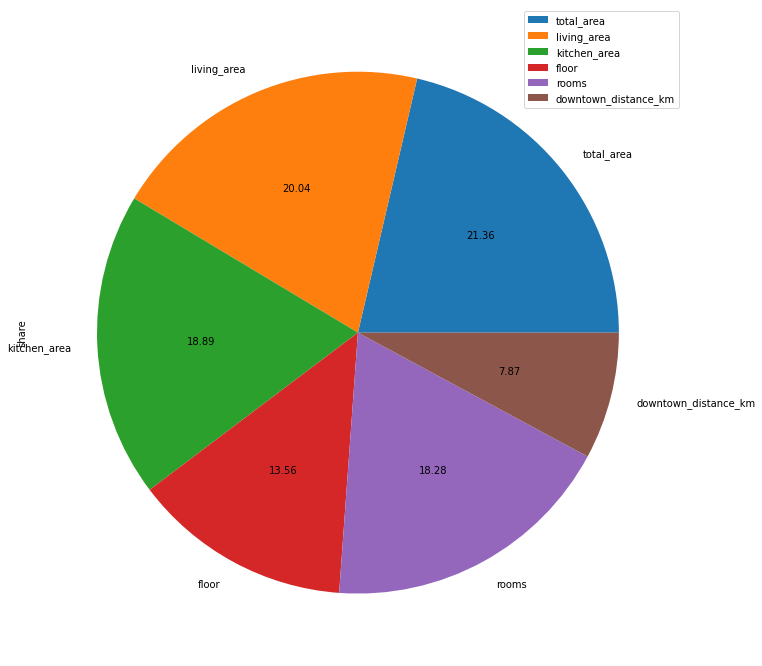

In [176]:
price_factors = ['total_area', 'living_area', 'kitchen_area', 'floor', 'rooms', 
                 'downtown_distance_km'] #'floor_category',
price_factors_share = []

for factor in price_factors:
    price_factors_share.append(df['last_price'].corr(df[factor]) + 1)
    #df.plot(x=factor, y='last_price', kind='scatter')
    #df[df['locality_name'] != 'Санкт-Петербург'].plot(x=factor, y='last_price', kind='scatter')

#print(price_factors_share)
    
    
df_price_factors = pd.DataFrame(price_factors_share, columns=['share'], index=price_factors)
df_price_factors.plot(y='share', kind='pie', autopct='%.2f', figsize=(12,12));

Итак, на входе мы получили датасет с большим количеством отсутствующих данных, доходящих до 40%. Это повод указать на этот недочет разработчикам. Возможно имеет место неправильная выгрузка данных, либо поля при заполнении формы обрабатываются с ошибками, так что данные не попадают в базу. Почти половины данных не хватало по высоте потолков и по наличию балконов, а это были важные данные для нашего анализа.

Мы приняли отсутствие данных о балконах за 0, а высоту потолков рассчитали в зависимости от местоположения и сегмента продаваемой квартиры. Другие аномалии были малочисленны и их мы просто отфильтровали.

После приведения датасета Яндекс.Недвижимости к надлежащему виду, мы провели анализ объектов недвижимости по нескольким параметрам. Мы определили, что объекты недвижимости, объявления о которых размещены на сервисе, продаются в среднем от двух месяцев до полугода. Стоимость, по корой пройдет эта сделка, будет зависеть в первую очередь, — от общей и, во-вторую, - от жилой площади квартиры. Третьим по влиянию фактором ускоряющим продажу является площадь кухни. Удаленность от центра города тоже оказывает влияние на формирование цены и скорость продажи квартиры, но не на столько существенно, как предыдущие факторы. Ближайшей альтернативой недвижимости с Санкт-Петербурге могут стать объекты в Пушкине, где подобный объект можно приобрести дешевле. Самые бюджетные варианты из первой десятки по стоимости квартир предлагает Выборг.

Средняя стоимость квартиры в данном нам датасете составляет 3-5 миллионов рублей. Максимальный спрос по этой цене на однокомнатные квартиры, с просторной кухней, не на первом и не на последнем этаже.

Дата публикации объявления никак не влияет на стоимость. Но объявления в два раза чаще публикуются по будням, чем по выходным. Традиционно активные месяцы публикации объявлений, - это февраль-апрель и осенние месяцы. Летом публикуется значительно меньше объявлений. А вот вероятность заключения сделки больше всего по вторникам.

Дольше полугода продаются квартиры с необычными параметрами. Это как правило дорогие объекты с большим количеством комнат и общей площадью выше 200 м2.


**Рекомендации по улучшению сервиса:**

В целом, учитывая выявленные выше коррелирующие факторы, рекомендуется немного изменить функционал. При публикации на основании введенных параметров по объекту, можно сразу выдавать приблизительный срок продажи, и рекомендовать чуть более низкую цену, если для владельца объекта время является критически важным параметром. Взаимосвязь стоимости и срока продажи можно было бы сделать прямо в виде графика с бегунком, чтобы продавец мог определить для себя наилучший баланс этих факторов, основываясь на прошлых статистических данных.

Наверняка, в системе уже есть платное продвижение, в этом случае продвижение по вторникам рекомендуется сделать более дорогим, так как это наиболее вероятный день для заключения сделок.

Для потенциальных покупателей, ищущих варианты на сервисе, дополнительно к их запросам, можно было бы сделать сопутствующею рекомендательную систему, предлагающую чуть более дорогие варианты, но с большей кухней, или с даже с меньшим санузлом, но с большей жилой площадью. Это одни из главных вариантов влияющих на цену, а значит квартиры с такими параметрами приобретать выгоднее. Для сервиса привлекать таким образом клиентов прибыльнее за счет повышенной комиссии за более крупные сделки. Предлагать другой этаж или другую удаленность от центра не рекомендуется, так как эти параметры оказывают малое влияние на цену.

В анализе мы выявили, что общая площадь объекта, это основной фактор ценообразования. Возможно, есть смысл добавить это поле в форму поиска на главной странице сервиса, чтобы покупатели могли искать сразу по этому параметру. Так же рекомендуется добавить в поиск поле "цена за м2" и попробовать провести А/Б тесты в пробной рекламной кампании. На подобии Йота, когда выбираешь не тариф, а общую сумму за месяц, а система сама подбирает тариф. По общей площади, сумме или стоимости квадратного метра сервис мог бы предлагать соответствующие этому уровню объекты. Вся информация, чтобы реализовать подобный функционал есть в предоставленном нам датасете.